In [10]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import seaborn as sns


# # # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# # import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse

In [ ]:
# # Nucleosome Core Particle
# loc = '/Users/thor/surfdrive/Projects/Nucleosome/production_run/'
# traj = md.load(loc+'dry.xtc', top=loc+'dry.pdb',stride=250)
# traj.center_coordinates()

# # find index of residue somewhere in the middle of the nucleosome
# indices = traj.top.select('resSeq 73 and chainid 7')
# residx = traj.topology.atom(indices[0]).residue.index
# anchor_molecules=[set(traj.topology.residue(residx).atoms)]

# # put everything in the same box based on the anchor residue
# traj = traj.image_molecules(anchor_molecules=anchor_molecules)

# # H-NS
# path = '/Users/thor/surfdrive/Data/h-ns/NAR/md/0_highaff/FI/drytrajs/'
# dna = mdna.load(filename=path+'dry_0.xtc',top=path+'dry_0.pdb')

# dna.describe()


In [14]:
# Initiate a DNA simulation using OpenMM 
traj = mdna.sequence_to_md(sequence='GCAATATATTGC',time=1,time_unit='picoseconds',solvated=True, save_location='./data/')
traj.center_coordinates()

# find index of residue somewhere in the middle of the nucleosome
indices = traj.top.select('resid 4')
residx = traj.topology.atom(indices[0]).residue.index
anchor_molecules=[set(traj.topology.residue(residx).atoms)]

# put everything in the same box based on the anchor residue
traj = traj.image_molecules(anchor_molecules=anchor_molecules)
traj = traj.superpose(traj,0)

# Load the trajectory
dna = mdna.load(traj)


# Highlight how to extract mean reference frames and base reference frames
mean_frames = dna.get_frames()
print(mean_frames.shape)

base_frames = dna.get_base_frames()
for res, ref in base_frames.items():
    print(res, ref.shape)
    break

# Highlight how to extract rigid base parameters
base, names = dna.get_parameters(base=True)
print(base.shape, names)

step, names = dna.get_parameters(step=True)
print(step.shape, names)

params, names = dna.get_parameters()
print(params.shape, names)

name = 'twist'
para = dna.get_parameter(name)
print(para.shape)


# Example on how to plot the twist parameter

fig, ax = plt.subplots(figsize=[5,3])
color = 'tab:orange'
mean = np.mean(para, axis=0)
std = np.std(para, axis=0)
x = range(len(mean))

ax.fill_between(x, mean-std, mean+std, color=color, alpha=0.2)
ax.plot(mean, color=color,lw=1)    
ax.scatter(x=x,y=mean,color=color,s=10)
ax.set_title(name)
ax.set_ylabel(f'{name} [degrees]')
ax.set_xlabel('Base pair step')
ax.set_xticks(range(len(mean)))
base_map = dna.base_pair_map
anti_sequence = [base_map[c] for c in dna.sequence ]
base_pairs = [f'{i}-{j}' for i,j in zip(dna.sequence, anti_sequence)]
_ = ax.set_xticklabels(base_pairs,rotation=45)


# Example on how to plot KDE's of all parameters
import matplotlib as mpl, matplotlib.font_manager as font_manager
import seaborn as sns

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

colors = sns.color_palette("twilight", 12)
lims = [(-2,2),(-2,2),(-2,2),(-65,65),(-65,65),(-65,65)] + [(-3,3),(-3,3),(1.25,5),(-50,50),(-50,50),(0,60)]
fig, ax = plt.subplots(3,4, figsize=(6,2.5),sharey='col')
# ax = ax.flatten()
idx, jdx = 0, 0
for _,name in enumerate(names):
    para = params[:,1:,names.index(name)]
    sns.kdeplot(para.flatten(), ax=ax[idx][jdx],fill=True,color='white',lw=5)#, density=True)
    sns.kdeplot(para.flatten(), ax=ax[idx][jdx],fill=True,color=colors[_],alpha=1,lw=1)#, density=True)
    ax[idx][jdx].set_title(name,x=0,y=0,color=colors[_],fontsize=10)
    ax[idx][jdx].set_xlim(lims[_])

    ax[idx][jdx].set_facecolor('none')
    ax[idx][jdx].set_yticklabels([])
    ax[idx][jdx].set_yticks([])
    ax[idx][jdx].set_ylabel('')
    if name  in ['shear','buckle','shift','tilt','stretch','propeller']:
        ax[idx][jdx].set_xticks([])
    idx+=1
    if idx == 3:
        idx = 0
        jdx+=1
    if jdx == 4:
        jdx = 0

    if idx == 0 and jdx in [0,1,2,3]:
        ax[idx][jdx].set_xticklabels([])
    if idx == 1 and jdx in [0,1]:
        ax[idx][jdx].set_xticklabels([])

ax[-1][0].set_xlabel('[nm]',fontsize=11)
ax[-1][1].set_xlabel('[degrees]',fontsize=11)
ax[-1][2].set_xlabel('[nm]',fontsize=11)
ax[-1][3].set_xlabel('[degrees]',fontsize=11)
fig.tight_layout()
fig.subplots_adjust(hspace=-.25)

sns.despine(bottom=True, left=True)
fig.text(0.25, 0.85, 'Pair Parameters', ha='center',fontsize=10)
fig.text(0.75, 0.85, 'Step Parameters', ha='center',fontsize=10)


Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 12

Initialize DNA openMM simulation at 310 K for 1 ps time units
Solvate DNA with padding of 1.0 nm and 0.1 M KCl
Minimize energy
Run simulation for 500 steps
Simulation completed
Saved trajectory as: ./data/my_dna.h5


In [13]:
traj = mdna.sequence_to_md(sequence='GCAATATATTGC',time=1,time_unit='picoseconds',solvated=True, save_location='./data/')
traj.center_coordinates()

# find index of residue somewhere in the middle of the nucleosome
indices = traj.top.select('resid 4')
residx = traj.topology.atom(indices[0]).residue.index
anchor_molecules=[set(traj.topology.residue(residx).atoms)]

# put everything in the same box based on the anchor residue
traj = traj.image_molecules(anchor_molecules=anchor_molecules)

traj = traj.superpose(traj,0)


Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 12

Initialize DNA openMM simulation at 310 K for 1 ps time units
Solvate DNA with padding of 1.0 nm and 0.1 M KCl
Minimize energy
Run simulation for 500 steps
Simulation completed
Saved trajectory as: ./data/my_dna.h5


In [4]:
dna = mdna.load(traj)

In [5]:
mean_frames = dna.get_frames()
print(mean_frames.shape)

base_frames = dna.get_base_frames()
for res, ref in base_frames.items():
    print(res, ref.shape)
    break

(12, 4999, 4, 3)
DG1 (4999, 4, 3)


In [6]:
base, names = dna.get_parameters(base=True)
print(base.shape, names)

step, names = dna.get_parameters(step=True)
print(step.shape, names)

params, names = dna.get_parameters()
print(params.shape, names)

name = 'twist'
para = dna.get_parameter(name)
print(para.shape)

(4999, 12, 6) ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening']
(4999, 12, 6) ['shift', 'slide', 'rise', 'tilt', 'roll', 'twist']
(4999, 12, 12) ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening', 'shift', 'slide', 'rise', 'tilt', 'roll', 'twist']
(4999, 12)


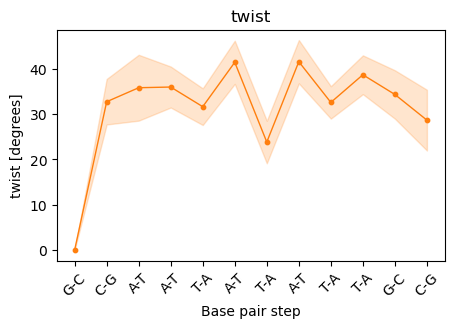

In [7]:

fig, ax = plt.subplots(figsize=[5,3])
color = 'tab:orange'
mean = np.mean(para, axis=0)
std = np.std(para, axis=0)
x = range(len(mean))

ax.fill_between(x, mean-std, mean+std, color=color, alpha=0.2)
ax.plot(mean, color=color,lw=1)    
ax.scatter(x=x,y=mean,color=color,s=10)
ax.set_title(name)
ax.set_ylabel(f'{name} [degrees]')
ax.set_xlabel('Base pair step')
ax.set_xticks(range(len(mean)))
base_map = dna.base_pair_map
anti_sequence = [base_map[c] for c in dna.sequence ]
base_pairs = [f'{i}-{j}' for i,j in zip(dna.sequence, anti_sequence)]
_ = ax.set_xticklabels(base_pairs,rotation=45)

Text(0.75, 0.85, 'Step Parameters')

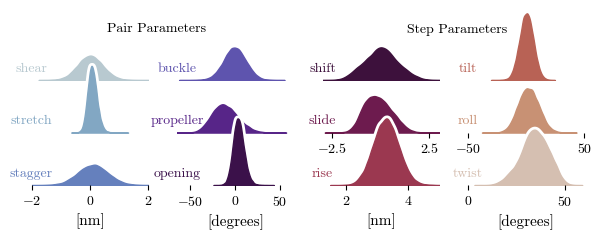

In [8]:
import matplotlib as mpl, matplotlib.font_manager as font_manager
import seaborn as sns

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

colors = sns.color_palette("twilight", 12)
lims = [(-2,2),(-2,2),(-2,2),(-65,65),(-65,65),(-65,65)] + [(-3,3),(-3,3),(1.25,5),(-50,50),(-50,50),(0,60)]
fig, ax = plt.subplots(3,4, figsize=(6,2.5),sharey='col')
# ax = ax.flatten()
idx, jdx = 0, 0
for _,name in enumerate(names):
    para = params[:,1:,names.index(name)]
    sns.kdeplot(para.flatten(), ax=ax[idx][jdx],fill=True,color='white',lw=5)#, density=True)
    sns.kdeplot(para.flatten(), ax=ax[idx][jdx],fill=True,color=colors[_],alpha=1,lw=1)#, density=True)
    ax[idx][jdx].set_title(name,x=0,y=0,color=colors[_],fontsize=10)
    ax[idx][jdx].set_xlim(lims[_])

    ax[idx][jdx].set_facecolor('none')
    ax[idx][jdx].set_yticklabels([])
    ax[idx][jdx].set_yticks([])
    ax[idx][jdx].set_ylabel('')
    if name  in ['shear','buckle','shift','tilt','stretch','propeller']:
        ax[idx][jdx].set_xticks([])
    idx+=1
    if idx == 3:
        idx = 0
        jdx+=1
    if jdx == 4:
        jdx = 0

    if idx == 0 and jdx in [0,1,2,3]:
        ax[idx][jdx].set_xticklabels([])
    if idx == 1 and jdx in [0,1]:
        ax[idx][jdx].set_xticklabels([])

ax[-1][0].set_xlabel('[nm]',fontsize=11)
ax[-1][1].set_xlabel('[degrees]',fontsize=11)
ax[-1][2].set_xlabel('[nm]',fontsize=11)
ax[-1][3].set_xlabel('[degrees]',fontsize=11)
fig.tight_layout()
fig.subplots_adjust(hspace=-.25)

sns.despine(bottom=True, left=True)
fig.text(0.25, 0.85, 'Pair Parameters', ha='center',fontsize=10)
fig.text(0.75, 0.85, 'Step Parameters', ha='center',fontsize=10)

In [ ]:
view = nv.show_mdtraj(traj[::100])
view